In [11]:
import numpy as np
from crccheck.crc import Crc16CcittFalse as Crc
import scipy.linalg
import matplotlib.pyplot as plt

In [12]:
## https://teslabs.com/articles/magnetometer-calibration/
def get_magnetometer_coords(s, F=1):
    print(F)
    M, n, d = ellipsoid_fit(s)
    Mi = np.linalg.inv(M)
    b = -Mi@n
    Ai = np.real(F / np.sqrt((n.T@Mi@n - d)) * scipy.linalg.sqrtm(M))
    return Ai, b

def ellipsoid_fit(s):
        ''' Estimate ellipsoid parameters from a set of points.

            Parameters
            ----------
            s : array_like
              The samples (M,N) where M=3 (x,y,z) and N=number of samples.

            Returns
            -------
            M, n, d : array_like, array_like, float
              The ellipsoid parameters M, n, d.

            References
            ----------
            .. [1] Qingde Li; Griffiths, J.G., "Least squares ellipsoid specific
               fitting," in Geometric Modeling and Processing, 2004.
               Proceedings, vol., no., pp.335-340, 2004
        '''
        # D (samples)
        D = np.array([s[0]**2., s[1]**2., s[2]**2.,
                      2.*s[1]*s[2], 2.*s[0]*s[2], 2.*s[0]*s[1],
                      2.*s[0], 2.*s[1], 2.*s[2], np.ones_like(s[0])])

        # S, S_11, S_12, S_21, S_22 (eq. 11)
        S = D @ D.T
        S_11 = S[:6,:6]
        S_12 = S[:6,6:]
        S_21 = S[6:,:6]
        S_22 = S[6:,6:]

        # C (Eq. 8, k=4)
        C = np.array([[-1,  1,  1,  0,  0,  0],
                      [ 1, -1,  1,  0,  0,  0],
                      [ 1,  1, -1,  0,  0,  0],
                      [ 0,  0,  0, -4,  0,  0],
                      [ 0,  0,  0,  0, -4,  0],
                      [ 0,  0,  0,  0,  0, -4]])

        # v_1 (eq. 15, solution)
        E = np.dot(np.linalg.inv(C),
                   S_11 - np.dot(S_12, np.dot(np.linalg.inv(S_22), S_21)))

        E_w, E_v = np.linalg.eig(E)

        v_1 = E_v[:, np.argmax(E_w)]
        if v_1[0] < 0: v_1 = -v_1

        # v_2 (eq. 13, solution)
        v_2 = np.dot(np.dot(-np.linalg.inv(S_22), S_21), v_1)

        # quadric-form parameters
        M = np.array([[v_1[0], v_1[3], v_1[4]],
                      [v_1[3], v_1[1], v_1[5]],
                      [v_1[4], v_1[5], v_1[2]]])
        n = np.array([[v_2[0]],
                      [v_2[1]],
                      [v_2[2]]])
        d = v_2[3]

        return M, n, d


In [9]:
filename = "/media/voit/A171-A6E6/data3488045469.dat"

data_desc = {
    '0x0020': { 'len': 2, 'type': np.uint32 },   # Time (ms, µs)
    '0x4020': { 'len': 3, 'type': np.int16 },   # Accelerometer (x, y, z)
    '0x8020': { 'len': 3, 'type': np.int16 },   # Gyroscope (x, y, z)
    '0xc020': { 'len': 3, 'type': np.int16 },   # Magnetometer (x, y, z)
    '0xf120': { 'len': 1, 'type': np.float32 },  # Pressure (hPa)
    '0x0810': { 'len': 1, 'type': np.float32 },  # Temp (°C)
}

data = { key: [] for key in data_desc }

with open(filename,"rb") as f:
    while code := "{0:#0{1}x}".format(np.fromfile(f, np.uint16, 1)[0],6):
        if code not in data_desc:
            print(f"Unknown code {code}")
            break
            
        data_field = np.fromfile(f, data_desc[code]['type'], data_desc[code]['len']);
        if data_field.size != data_desc[code]['len']:
            break
            
        data[code].append(data_field)
        
        crc = np.fromfile(f, np.uint16, 1)
        if crc.size != 1:
            break
        if not crc[0] == Crc.calc(data_field.tobytes()):
            print(f"CRC error at {f.tell()}, code {code}") 

for key in data:
    data[key] = np.array(data[key])

In [14]:
Ai,b = get_magnetometer_coords(data["0xc020"].T, F=0.0491)

mag_data_calib = Ai@(data["0xc020"].T - b)

0.0491


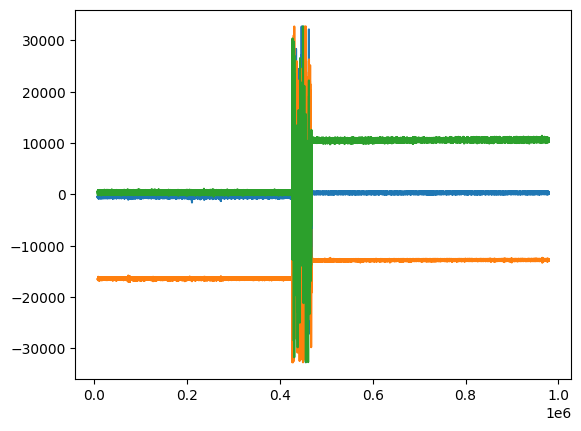

In [10]:
plt.figure
plt.plot(data["0x0020"][:,0],data["0x4020"][:,0])
plt.plot(data["0x0020"][:,0],data["0x4020"][:,1])
plt.plot(data["0x0020"][:,0],data["0x4020"][:,2])

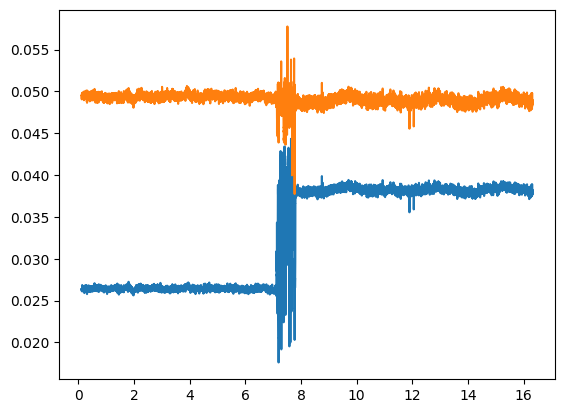

In [19]:
plt.figure
plt.plot(data["0x0020"][:,0]/60000, np.linalg.norm(data["0xc020"]/100000, axis=1))
plt.plot(data["0x0020"][:,0]/60000, np.linalg.norm(mag_data_calib, axis=0))